In [1]:
import xarray as xr
import numpy as np
import cmocean as cm
import os
import pandas as pd
from matplotlib import cm as cmap
%matplotlib inline

In [2]:
from dask.distributed import Client

In [3]:
c=Client()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41499,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://127.0.0.1:35517,Total threads: 4
Dashboard: /proxy/43197/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:32961,


In [4]:
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import matplotlib.ticker as mticker
import cmocean as cm

In [5]:
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='#DFD1AF',
                                        linewidth=0.2)

In [6]:
import matplotlib
matplotlib.rcParams["text.latex.preamble"] = r'\usepackage{xfrac}'

In [7]:
climatology_path = '/home/156/jm5970/hh5/climatology_V2/'

In [8]:
MKE = xr.open_dataset(climatology_path+'./MKE_climatology.nc').rename({'__xarray_dataarray_variable__':'MKE','latitude':'lat','longitude':'lon'})/10000
MEKE = xr.open_dataset(climatology_path+'./MEKE_climatology.nc').rename({'EKE_eddy':'MEKE'})
MCEKE = xr.open_dataset(climatology_path+'./MTEKE_climatology.nc').rename({'EKE_eddy':'MCEKE'})
MREKE = xr.open_dataset(climatology_path+'./MTRKE_climatology.nc').rename({'EKE_res':'MREKE'})
MREKE_c = xr.open_dataset(climatology_path+'./MTRKE_c_climatology.nc').rename({'TEKE_c':'MREKE_c'})

In [9]:
# gridded_depth.to_netcdf('/home/156/jm5970/v45/data.input/bathymetry_025deg.nc')
gridded_depth=xr.open_mfdataset('/home/156/jm5970/v45/data.input/bathymetry_025deg.nc').elevation

In [14]:
eddy_climat =xr.open_dataset('../datasets/climatology/gridded_TrackEddy_stats_climatology.nc')

In [15]:
MKE = (MKE).where(abs(MKE.lat)<60).where(abs(MKE.lat)>5)
MEKE = (MEKE).where(abs(MKE.lat)<60).where(abs(MKE.lat)>5)
MCEKE = (MCEKE).where(abs(MKE.lat)<60).where(abs(MKE.lat)>5)
MREKE = (MREKE).where(abs(MKE.lat)<60).where(abs(MKE.lat)>5)
MREKE_c = (MREKE_c).where(abs(MKE.lat)<60).where(abs(MKE.lat)>5)

In [16]:
MCEKE = MCEKE.where(MKE.lon<358).where(MKE.lon>2).interpolate_na(dim="lon", method="linear", fill_value="extrapolate")

In [17]:
def get_mask(dataset,coord1,coord2):
    if coord1 > 0 :
        return slice(coord1,coord2)
    else:
        return dataset.lon.where((dataset.lon > coord1+360) | (dataset.lon < coord2)).dropna('lon')

In [18]:
eddy_climat_ts = xr.open_mfdataset('/g/data/v45/jm5970/scripts_papers/paper_transient_climatology/netcdf_V2/eddy_stats_timeseries_*.nc').chunk({'time':189})

In [19]:
eddy_climat_ts

<xarray.Dataset>
Dimensions:   (time: 10016, lat: 140, lon: 361)
Coordinates:
  * lon       (lon) float64 0.1 1.1 2.1 3.1 4.1 ... 357.1 358.1 359.1 359.9
  * lat       (lat) int64 -70 -69 -68 -67 -66 -65 -64 ... 63 64 65 66 67 68 69
  * time      (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-06-03
Data variables:
    eddy_a    (time, lat, lon) float64 dask.array<chunksize=(189, 140, 361), meta=np.ndarray>
    eddy_a_p  (time, lat, lon) float64 dask.array<chunksize=(189, 140, 361), meta=np.ndarray>
    eddy_a_n  (time, lat, lon) float64 dask.array<chunksize=(189, 140, 361), meta=np.ndarray>
    eddy_n    (time, lat, lon) float64 dask.array<chunksize=(189, 140, 361), meta=np.ndarray>
    eddy_n_p  (time, lat, lon) float64 dask.array<chunksize=(189, 140, 361), meta=np.ndarray>
    eddy_n_n  (time, lat, lon) float64 dask.array<chunksize=(189, 140, 361), meta=np.ndarray>

In [20]:
def crop_extend(slices):
    return [slices[0],slices[1]-1,slices[2],slices[3]]

In [21]:
eddy_climat_ts = eddy_climat_ts.load()

In [22]:
path='/g/data/rr7/JRA55/6hr/atmos/'

In [23]:
u_10_p='uas/v1/uas_*.nc'
v_10_p='vas/v1/vas_*.nc'

In [24]:
u_10=xr.open_mfdataset(path+u_10_p,combine='nested',concat_dim='time',chunks={'time':100,'lon':320,'lat':160},parallel=True)
v_10=xr.open_mfdataset(path+v_10_p,combine='nested',concat_dim='time',chunks={'time':100,'lon':320,'lat':160},parallel=True)

In [25]:
wind_mag = np.sqrt(u_10.uas**2 + v_10.vas**2)

In [26]:
wind_mag = wind_mag.chunk({'time':100})

In [27]:
def cor(y1, y2):
    n = len(y1)
    nc = int(n/3.5)
    
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    
    
    cor = np.zeros(nc)
    for j in np.arange(0, nc):
        moved=np.roll(y1, j)
        moved[:j]=np.nan
        cor[j] = np.nanmean(moved*y2)/np.sqrt(np.nanmean(y1**2)*np.nanmean(y2**2))
    return cor

In [28]:
# path="/g/data/ua8/CMEMS_SeaLevel/v2019/*/*.nc"
# SSH_data=xr.open_mfdataset(path,chunks={'latitude': 720, 'longitude': 1440, 'time': 10},parallel=True)
# mssh = SSH_data.adt.mean('time').compute()


In [29]:
# mssh.to_netcdf('../datasets/mean_satellite_SSH.nc')
mssh_data = xr.open_dataset('../datasets/mean_satellite_SSH.nc')

In [30]:
mssh = mssh_data.adt

In [31]:
from correlation import correlation as Ccor# Compute_Correlation

In [32]:
from matplotlib import colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Truncate colormap.
    """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [33]:
lat_radians=np.radians(eddy_climat_ts.lat)
lon_radians=np.radians(eddy_climat_ts.lon)
earth_radius = 6371e3

grad_lon=lon_radians.copy()
grad_lon.data=np.gradient(lon_radians)

dx=grad_lon*earth_radius*np.cos(lat_radians)
dy=np.gradient(lat_radians)*earth_radius

area = (dx*dy).where(abs(dx.lat)>5)
area = area.where(eddy_climat_ts.eddy_n>0)

Region & Correlation & Lag & Correlation & Lag  & Correlation & Lag & Ratio & Correlation cEddyn \& cEddyamp  \\


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))


Gulf Stream & 0.98 & 2.6 & 0.99  & 6.2 & 0.99  & 7.6 & 55.86 & -0.56 \
Kuroshio Current & 0.99 & 2.6 & 0.98  & 7.1 & 0.97  & 6.8 & 56.50 & -0.54 \


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))


Agulhas Current & 0.98 & 1.3 & 0.98  & 4.3 & 0.96  & 6.7 & 56.45 & -0.38 \
Leeuwin Current & 0.99 & 1.7 & 0.75  & 0.2 & 0.94  & 2.7 & 65.85 & -0.59 \


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))


East Tropical Pacific & 0.85 & 3.8 & 0.90  & 0.4 & 0.63  & 6.3 & 58.14 & -0.45 \


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))


Tropical Pacific & 0.74 & 1.0 & 0.68  & 6.0 & 0.86  & 5.1 & 61.29 & -0.69 \


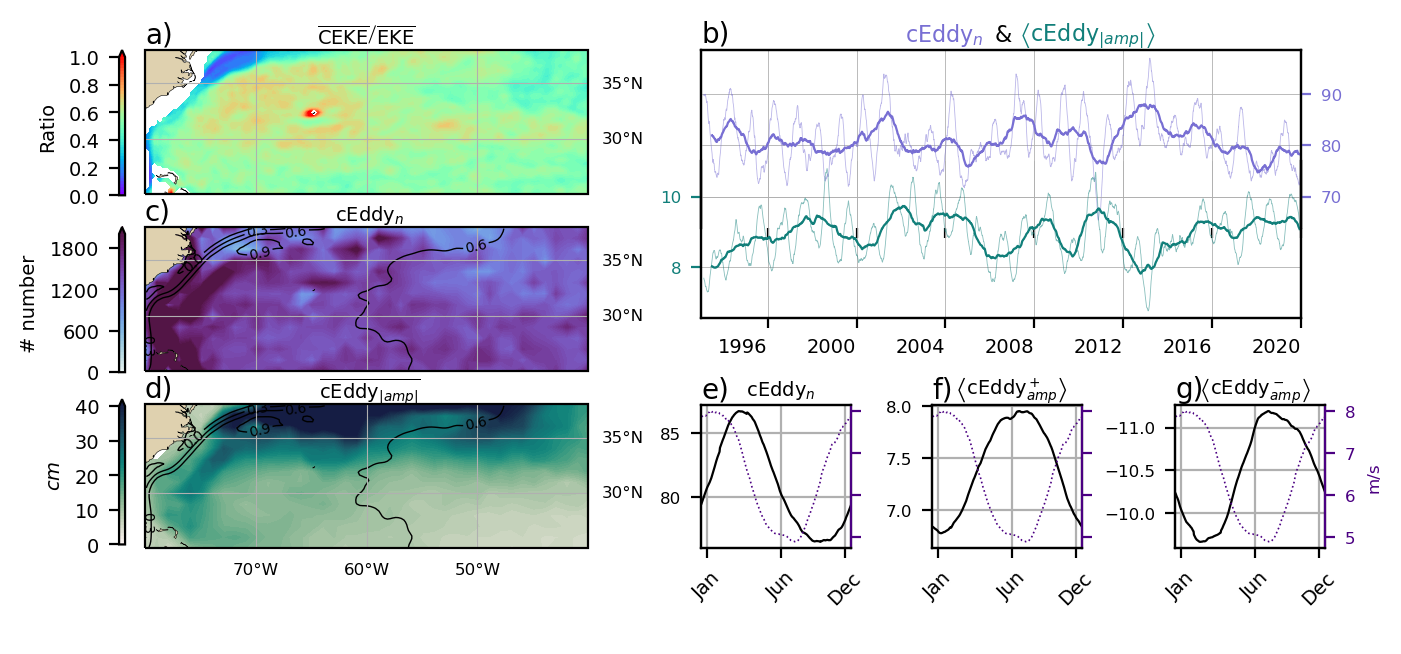

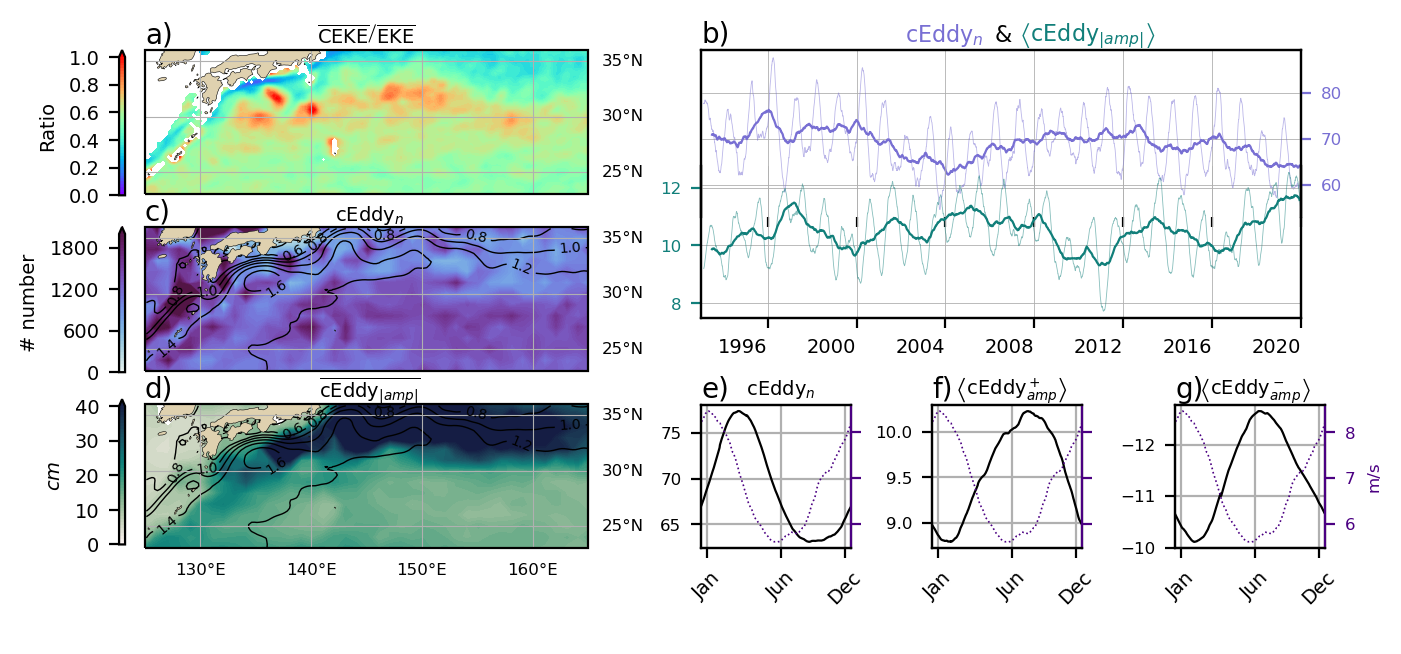

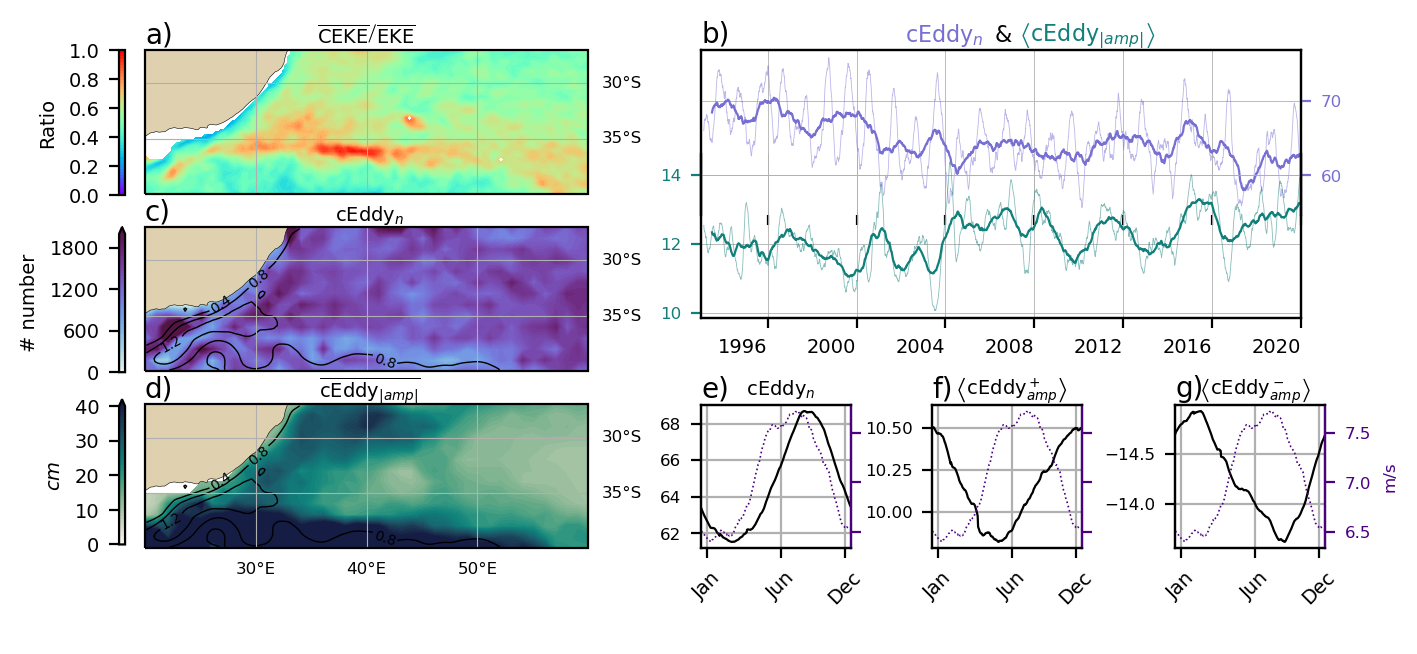

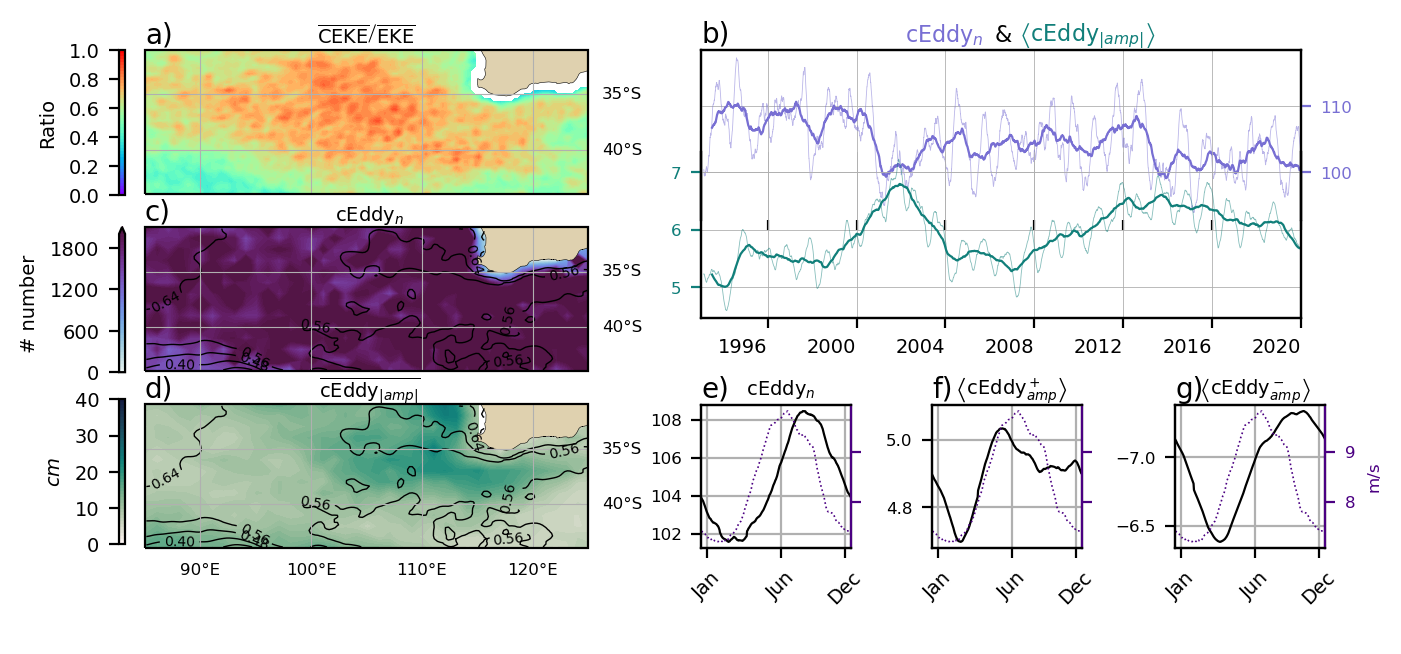

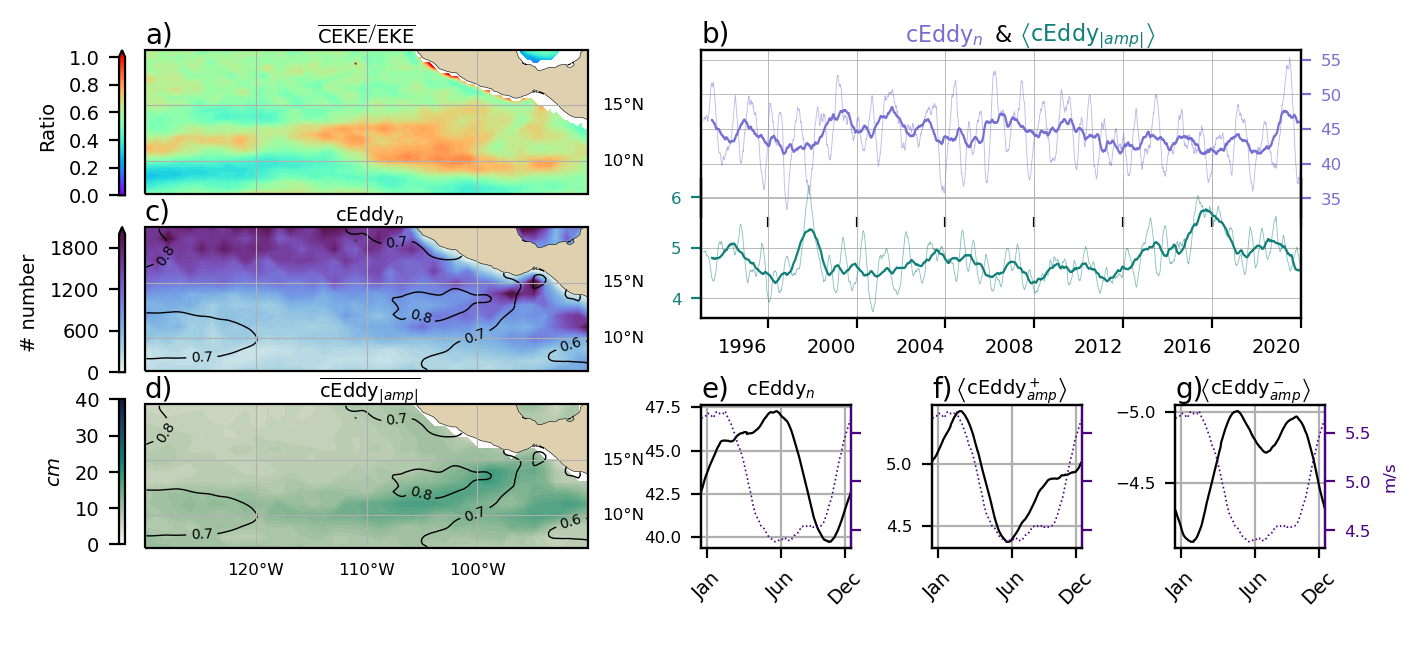

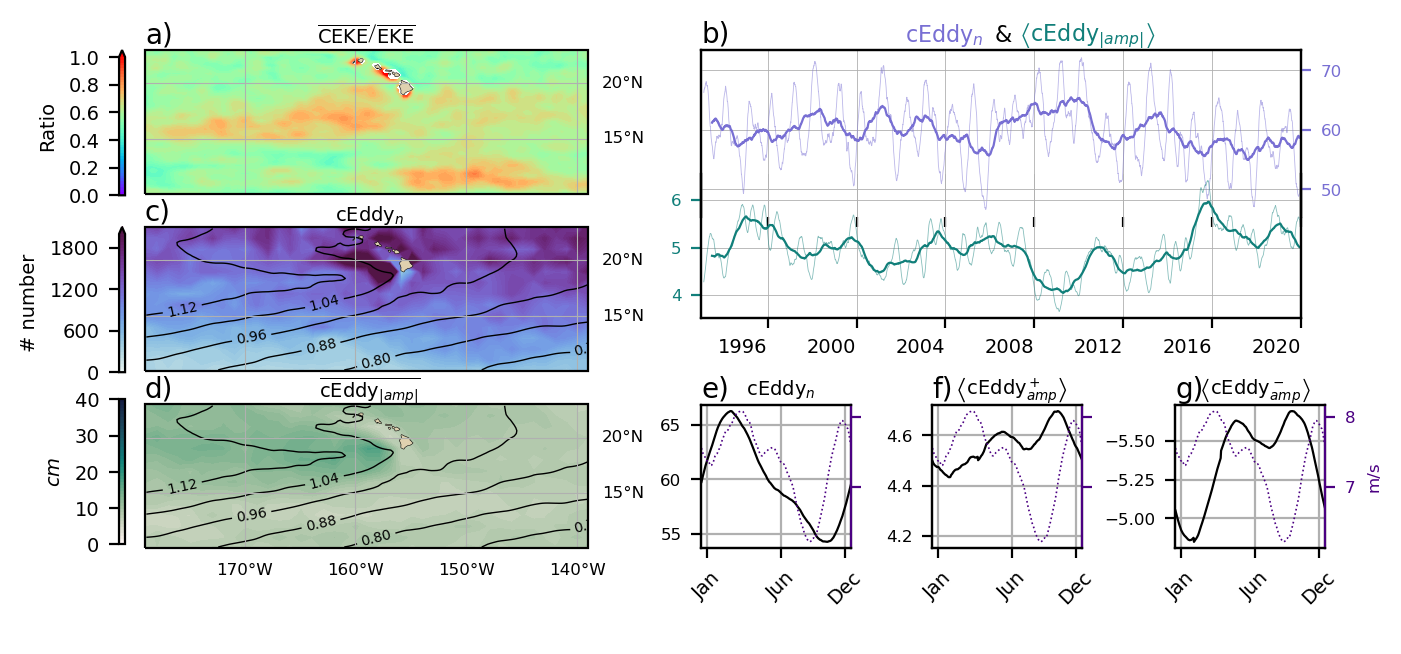

In [34]:
slices = [
        [ 280,321, 25, 38 ],
        [ 125, 166, 23,36],
        [ 20, 61, -40, -27 ],
        [ 85, 126, -44,-31 ],
        [ 230,271, 7,20 ],
        [ 181,222, 10,23 ],
         ]

locations = [
        [-0.052,+0.052,0.08,0.0195],
        [-0.035,+0.035,0.08,0.013],
        [-0.032,+0.032,0.08,0.030],
        [-0.04,+0.04,0.08,0.034],
        [-0.035,+0.035,0.08,-0.007],
        [-0.035,+0.035,0.08,0],
        ]

regions=[
        'Gulf Stream',
        'Kuroshio Current',
        'Agulhas Current',
        'Leeuwin Current',
        'East Tropical Pacific',
        'Tropical Pacific',
        ]

print("Region & Correlation & Lag & Correlation & Lag  & Correlation & Lag & Ratio & Correlation cEddyn \& cEddyamp  \\\\")

counter = 0    
for ii in range(len(slices)):
    fig, (ax) = plt.subplots(3, 1, figsize=(3, 3.3),dpi=200, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    
    ax1 = ax[0]
    ax2 = ax[1]
    ax3 = ax[2]
    
    cmap = 'rainbow'

    cbar_kwargs=dict(pad=0.15, shrink=1, label=r'')

    area_selection  = area.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    #############################################################################
    MEKE_CEKE_ratio_section = (MCEKE.MCEKE/MEKE.MEKE).where(gridded_depth < -500).sel({'lon':get_mask(MCEKE,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    #############################################################################
    eddy_c = eddy_climat_ts.eddy_n.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    eddy_a_p = eddy_climat_ts.eddy_a_p.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})*100
    eddy_a_n = eddy_climat_ts.eddy_a_n.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})*100 
    #############################################################################
    eddy_n_ts_90d = eddy_c.sum(('lat','lon')).rolling(time=90, center=True).mean()
    eddy_a_p_ts_90d = ((area_selection*eddy_a_p).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=90, center=True).mean()
    eddy_a_n_ts_90d = ((area_selection*eddy_a_n).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=90, center=True).mean()

    eddy_n_ts_360d = eddy_c.sum(('lat','lon')).rolling(time=360, center=True).mean()
    eddy_a_p_ts_360d = ((area_selection*eddy_a_p).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=360, center=True).mean()
    eddy_a_n_ts_360d = ((area_selection*eddy_a_n).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=360, center=True).mean()

    eddy_n_ts = eddy_n_ts_90d - eddy_n_ts_360d
    eddy_a_p_ts = (eddy_a_p_ts_90d-eddy_a_p_ts_360d)
    eddy_a_n_ts = (eddy_a_n_ts_90d-eddy_a_n_ts_360d)
    
    mssh_region = mssh.sel({'longitude':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'latitude':slice(slices[ii][2],slices[ii][3])}) 

    #############################################################################
    wind_mag_region = wind_mag.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])}).load()
    wind_mag_region_ts_90d = wind_mag_region.mean(('lat','lon')).rolling(time=120, center=True).mean().groupby('time.dayofyear').mean()
    #############################################################################
    
    clm = MEKE_CEKE_ratio_section.plot.contourf(ax=ax1,transform =ccrs.PlateCarree(),cmap='rainbow',
                                    vmin=0,vmax=1, add_colorbar = False,levels=50)
    for c in clm.collections:
        c.set_rasterized(True)
    ax1.add_feature(land_50m)
    ax1.set_extent(crop_extend(slices[ii]), crs=ccrs.PlateCarree())
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
    
    clm2 = eddy_c.sum('time').plot.contourf(ax=ax2,transform =ccrs.PlateCarree(),cmap=truncate_colormap(cm.cm.dense,0,0.9),
                                    vmin=0,vmax=2000, add_colorbar = False,levels=50)
    for c in clm2.collections:
        c.set_rasterized(True)
    
    CS = mssh_region.plot.contour(ax=ax2,transform =ccrs.PlateCarree(),colors='k',linewidths=0.5,levels=8)
    ax2.clabel(CS, inline=True, fontsize=5)
    
    ax2.add_feature(land_50m)
    ax2.set_extent(crop_extend(slices[ii]), crs=ccrs.PlateCarree())
    gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
    
    clm3 = ((eddy_a_p.mean("time") - eddy_a_n.mean('time'))/2).plot.contourf(ax=ax3,transform =ccrs.PlateCarree(),cmap=cm.cm.tempo,
                                    vmin=0,vmax=40, add_colorbar = False,levels=50)
    
    for c in clm3.collections:
        c.set_rasterized(True)
        
    CS = mssh_region.plot.contour(ax=ax3,transform =ccrs.PlateCarree(),colors='k',linewidths=0.5,levels=8)
    ax3.clabel(CS, inline=True, fontsize=5)
    
    ax3.add_feature(land_50m)
    ax3.set_extent(crop_extend(slices[ii]), crs=ccrs.PlateCarree())
    gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
    
    #############################################################################
    
    ax4_n = fig.add_axes([1.02+0.05, 0.662+locations[ii][0], 1, 0.218+locations[ii][1]])
    ax4 = ax4_n.twinx()
    ax5_n = fig.add_axes([1.02+0.05, 0.394+locations[ii][2], 1, 0.218+locations[ii][3]])
    ax5 = ax5_n.twinx()
    
    #############################################################################
    
    eddy_n_ts_90d.plot(ax=ax4, color='#786fd3',linewidth=0.3,alpha=0.5)  
    eddy_n_ts_360d.plot(ax=ax4, color='#786fd3',linewidth=0.8,label='$cEddy_{n}$')
    
    ax4.grid(linewidth=0.3)
    ax4_n.grid(linewidth=0.3)
    ax4.set_xlim(('1993','2020'))
    
    ax4_n.set_yticklabels([])
    ax4_n.spines['bottom'].set_visible(False)
    ax4.spines['bottom'].set_visible(False)
    ax4_n.yaxis.set_visible(False)
    ax4.yaxis.set_tick_params(labelsize=6,color='#786fd3')
    
    ax4.tick_params(axis='y', colors='#786fd3')
    
    ax4.set_xticklabels([])
    ax4.set_ylabel('')
    
    sum_long_0d = (( eddy_a_p.mean(('lon','lat')) - eddy_a_n.mean(('lon','lat')) )/2)
    sum_long_rolling_90d = ( eddy_a_p_ts_90d - eddy_a_n_ts_90d )/2
    sum_long_rolling = ( eddy_a_p_ts_360d - eddy_a_n_ts_360d )/2
    
    sum_long_rolling_90d.plot(ax=ax5_n, color='#117f7a',linewidth=0.3,alpha=0.5)  
    sum_long_rolling.plot(ax=ax5_n,color='#117f7a',linewidth=0.8,label='$ \overline{\sum cEddy_{amp}}$')
    
    ax5.grid(linewidth=0.3)
    ax5_n.grid(linewidth=0.3)
        
    ax5_n.set_xlim(('1993','2020'))
    
    ax5_n.patch.set_alpha(0)
    ax5.patch.set_alpha(0)
    ax5_n.tick_params(axis='x', labelrotation=0)
    ax5_n.spines['top'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.yaxis.set_visible(False)

    ax5.set_ylabel('')
    ax5_n.set_xlabel('')
    
    ax5.set_yticklabels([])
    ax5.yaxis.set_tick_params(labelsize=6)
    ax5_n.yaxis.set_tick_params(labelsize=6,color='#117f7a')
    ax5_n.xaxis.set_tick_params(labelsize=7)  
    
    ax5_n.tick_params(axis='y', colors='#117f7a')
    
    ###############################################################################
    ################################################################################
    
    ax7 = fig.add_axes([1.02+0.05, 0.125, 0.25, 0.218])
    ax8 = fig.add_axes([1.38+0.075, 0.125, 0.25, 0.218])
    ax9 = fig.add_axes([1.76+0.1, 0.125, 0.25, 0.218])
    
    eddy_seasonal = eddy_c.sum(('lat','lon')).rolling(time=30*3, center=True).mean()
    n_eddy_year= eddy_seasonal.groupby('time.dayofyear').mean()
    n_eddy_year.plot(ax=ax7, color='k',linewidth=0.8)
    ax7_t = ax7.twinx()
    wind_mag_region_ts_90d.plot(ax=ax7_t, color='indigo',linewidth=0.6,linestyle=':')
    
    eddy_a_p_seasonal = ((eddy_a_p*area_selection).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=30*3, center=True).mean()
    eddy_a_p_eddy_year = eddy_a_p_seasonal.groupby('time.dayofyear').mean()
    eddy_a_p_eddy_year.plot(ax=ax8, color='k',linewidth=0.8)
    ax8_t = ax8.twinx()
    wind_mag_region_ts_90d.plot(ax=ax8_t, color='indigo',linewidth=0.6,linestyle=':')
    
    eddy_a_n_seasonal = ((eddy_a_n*area_selection).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=30*3, center=True).mean()
    eddy_a_n_eddy_year = eddy_a_n_seasonal.groupby('time.dayofyear').mean()
    eddy_a_n_eddy_year.plot(ax=ax9, color='k',linewidth=0.8)
    ax9_t = ax9.twinx()
    wind_mag_region_ts_90d.plot(ax=ax9_t, color='indigo',linewidth=0.6,linestyle=':')
    
    ax7.set_xlim((0,365))
    ax8.set_xlim((0,365))
    ax9.set_xlim((0,365))
    
    ax7.set_xticks([15,180+15,335+15])
    ax8.set_xticks([15,180+15,335+15])
    ax9.set_xticks([15,180+15,335+15])
    
#     ax7_t.set_yticks([])
    ax7_t.set_xticklabels([])
    ax7_t.spines['right'].set_color('indigo')
    ax7_t.tick_params(axis='y', colors='indigo',labelsize=6,labelright=False)
#     ax8_t.set_yticks([])
    ax8_t.set_xticklabels([])
    ax8_t.spines['right'].set_color('indigo')
    ax8_t.tick_params(axis='y', colors='indigo',labelsize=6,labelright=False)
#     ax9_t.set_yticks([])
#     ax9_t.set_xticklabels([])
    ax9_t.spines['right'].set_color('indigo')
    ax9_t.tick_params(axis='y', colors='indigo',labelsize=6)
    ax9_t.set_ylabel('m/s', color='indigo',fontsize=6)
    
    ax7.set_xticklabels(['Jan','Jun','Dec'],rotation=45)
    ax8.set_xticklabels(['Jan','Jun','Dec'],rotation=45)
    ax9.set_xticklabels(['Jan','Jun','Dec'],rotation=45)
    
    ax7.tick_params(axis='x', labelrotation=45)
    ax8.tick_params(axis='x', labelrotation=45)
    ax9.tick_params(axis='x', labelrotation=45)
    
    ax7.set_ylabel(' ', fontsize=6)
    ax8.set_ylabel(' ', fontsize=6)
    ax9.set_ylabel(' ', fontsize=6)
    
    ax7.set_xlabel(' ', fontsize=6)
    ax8.set_xlabel(' ', fontsize=6)
    ax9.set_xlabel(' ', fontsize=6)

    ax7.yaxis.set_tick_params(labelsize=6)
    ax8.yaxis.set_tick_params(labelsize=6)    
    ax9.yaxis.set_tick_params(labelsize=6) 
    
    ax7.xaxis.set_tick_params(labelsize=7)  
    ax8.xaxis.set_tick_params(labelsize=7)  
    ax9.xaxis.set_tick_params(labelsize=7) 
    
    ax9.invert_yaxis()
    
    ax7.grid()
    ax8.grid()
    ax9.grid()
    
    ax1.set_title( r'$\overline{\mathrm{CEKE}}\left/\overline{\mathrm{EKE}}\right.$', fontsize=7,y=0.93)
    ax2.set_title(' $\mathrm{cEddy}_{n}$', fontsize=7,y=0.93)
    ax3.set_title(' $\overline{\mathrm{cEddy}_{|amp|}}$', fontsize=7,y=0.93)
    
    ax4.text(0.34, 1.05, r'$\mathrm{cEddy}_{n}$', fontsize=8,transform=ax4.transAxes,color='#786fd3')
    ax4.text(0.49, 1.05, r'&', fontsize=8,transform=ax4.transAxes,color='k')
    ax4.text(0.53, 1.05, r'$\left<\mathrm{cEddy}_{|amp|}\right>$', fontsize=8,transform=ax4.transAxes,color='#117f7a')
    
    ax7.set_title(' $\, \mathrm{cEddy}_{n}$', fontsize=7,y=0.95)
    ax8.set_title(r' $\, \left<\mathrm{cEddy}_{amp}^+\right>$', fontsize=7,y=0.95)
    ax9.set_title(r' $\, \left<\mathrm{cEddy}_{amp}^-\right>$', fontsize=7,y=0.95)
    
    cbar_ax = fig.add_axes([0.1, 0.66, 0.01, 0.22])
    cbar=fig.colorbar(clm, cax=cbar_ax, orientation='vertical',ticks=np.arange(0,1.1,0.2))
    cbar.set_label('Ratio', rotation=90, fontsize=7)
    cbar.ax.tick_params(labelsize=7) 
    cbar.ax.yaxis.tick_left()
    cbar.ax.yaxis.set_label_position('left') 

    cbar_ax = fig.add_axes([0.1, 0.392, 0.01, 0.22])
    cbar=fig.colorbar(clm2, cax=cbar_ax, orientation='vertical',ticks=np.arange(0,2200,600))
    cbar.set_label('# number', rotation=90, fontsize=7)
    cbar.ax.tick_params(labelsize=7) 
    cbar.ax.yaxis.tick_left()
    cbar.ax.yaxis.set_label_position('left') 
    
    cbar_ax = fig.add_axes([0.1, 0.131, 0.01, 0.22])
    cbar=fig.colorbar(clm3, cax=cbar_ax, orientation='vertical',ticks=np.arange(0,41,10))
    cbar.set_label('$cm$', rotation=90, fontsize=7)
    cbar.ax.tick_params(labelsize=7) 
    cbar.ax.yaxis.tick_left()
    cbar.ax.yaxis.set_label_position('left')
    
    ax1.text(0.0,1.05,r'a)',fontsize=10,transform=ax1.transAxes)
    ax2.text(0.0,1.05,r'c)',fontsize=10,transform=ax2.transAxes)
    ax3.text(0.0,1.05,r'd)',fontsize=10,transform=ax3.transAxes)
    ax4.text(0.0,1.05,r'b)',fontsize=10,transform=ax4.transAxes)
    ax7.text(0.0,1.05,r'e)',fontsize=10,transform=ax7.transAxes)
    ax8.text(0.0,1.05,r'f)',fontsize=10,transform=ax8.transAxes)
    ax9.text(0.0,1.05,r'g)',fontsize=10,transform=ax9.transAxes)
    
    n_eddy_year
    eddy_a_n_eddy_year
    eddy_a_p_eddy_year
    
    
    c_cor_n = Ccor.Compute_Correlation(wind_mag_region_ts_90d, n_eddy_year,method="Cyclic")
    c_cor_a_n = Ccor.Compute_Correlation(wind_mag_region_ts_90d, -eddy_a_n_eddy_year,method="Cyclic")
    c_cor_a_p = Ccor.Compute_Correlation(wind_mag_region_ts_90d, eddy_a_p_eddy_year,method="Cyclic") 
    
    corr_n,sig,t = c_cor_n.cor_series()
    corr_an,sig,t = c_cor_a_n.cor_series()
    corr_ap,sig,t = c_cor_a_p.cor_series()

    cor_n_amp = np.corrcoef(eddy_n_ts_360d.dropna('time'), sum_long_rolling.dropna('time'))
    
    parse_corr = (regions[counter], corr_n.max(),corr_n.argmax()/30
                  ,corr_ap.max(),corr_ap.argmax()/30,corr_an.max(),corr_an.argmax()/30,
                  MEKE_CEKE_ratio_section.mean().values*100, cor_n_amp[0,1])

    
    print("{0} & {1:.2f} & {2:.1f} & {3:.2f}  & {4:.1f} & {5:.2f}  & {6:.1f} & {7:.2f} & {8:.2f} \\".format(*parse_corr))
    
    
    plt.subplots_adjust(wspace=0.05, hspace=0.23)
    plt.savefig('./Figure_{0}_{1}_regional_stats.pdf'.format(10+counter,regions[counter].replace(' ','_')),dpi=300,bbox_inches='tight')
    counter+=1

In [ ]:
!pwd

In [ ]:
slices = [
        [ 280,321, 25, 38 ],
         ]

locations = [
        [-0.052,+0.052,0.08,0.0195],
        ]

regions=[
        'Gulf Stream',
        ]

print("Region & Correlation & Lag & Correlation & Lag  & Correlation & Lag & Ratio & Correlation cEddyn \& cEddyamp  \\\\")

counter = 0    
for ii in range(len(slices)):
    fig, (ax) = plt.subplots(3, 1, figsize=(3, 3.3),dpi=200, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    
    ax1 = ax[0]
    ax2 = ax[1]
    ax3 = ax[2]
    
    cmap = 'rainbow'

    cbar_kwargs=dict(pad=0.15, shrink=1, label=r'')

    area_selection  = area.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    #############################################################################
    MEKE_CEKE_ratio_section = (MCEKE.MCEKE/MEKE.MEKE).where(gridded_depth < -500).sel({'lon':get_mask(MCEKE,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    #############################################################################
    eddy_c = eddy_climat_ts.eddy_n.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    eddy_c_p = eddy_climat_ts.eddy_n_p.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    eddy_c_n = eddy_climat_ts.eddy_n_n.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    #############################################################################
    eddy_n_ts_90d = eddy_c.sum(('lat','lon')).rolling(time=90, center=True).mean()
    eddy_n_p_ts_90d = eddy_c_p.count(('lat','lon')).rolling(time=90, center=True).mean()
    eddy_n_n_ts_90d = eddy_c_n.count(('lat','lon')).rolling(time=90, center=True).mean()

    eddy_n_ts_360d = eddy_c.sum(('lat','lon')).rolling(time=360, center=True).mean()
    eddy_n_p_ts_360d = eddy_c_p.count(('lat','lon')).rolling(time=360, center=True).mean()
    eddy_n_n_ts_360d = eddy_c_n.count(('lat','lon')).rolling(time=360, center=True).mean()

    eddy_n_ts = eddy_n_ts_90d - eddy_n_ts_360d
    eddy_n_p_ts = (eddy_a_p_ts_90d-eddy_a_p_ts_360d)
    eddy_n_n_ts = (eddy_a_n_ts_90d-eddy_a_n_ts_360d)
    
    mssh_region = mssh.sel({'longitude':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'latitude':slice(slices[ii][2],slices[ii][3])}) 

    #############################################################################
    wind_mag_region = wind_mag.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])}).load()
    wind_mag_region_ts_90d = wind_mag_region.mean(('lat','lon')).rolling(time=120, center=True).mean().groupby('time.dayofyear').mean()
    #############################################################################
    
    clm = MEKE_CEKE_ratio_section.plot.contourf(ax=ax1,transform =ccrs.PlateCarree(),cmap='rainbow',
                                    vmin=0,vmax=1, add_colorbar = False,levels=50)
    for c in clm.collections:
        c.set_rasterized(True)
    ax1.add_feature(land_50m)
    ax1.set_extent(crop_extend(slices[ii]), crs=ccrs.PlateCarree())
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
    
    clm2 = eddy_c.sum('time').plot.contourf(ax=ax2,transform =ccrs.PlateCarree(),cmap=truncate_colormap(cm.cm.dense,0,0.9),
                                    vmin=0,vmax=2000, add_colorbar = False,levels=50)
    for c in clm2.collections:
        c.set_rasterized(True)
    
    CS = mssh_region.plot.contour(ax=ax2,transform =ccrs.PlateCarree(),colors='k',linewidths=0.5,levels=8)
    ax2.clabel(CS, inline=True, fontsize=5)
    
    ax2.add_feature(land_50m)
    ax2.set_extent(crop_extend(slices[ii]), crs=ccrs.PlateCarree())
    gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
    
    clm3 = (eddy_c_p.count("time")).plot.contourf(ax=ax3,transform =ccrs.PlateCarree(),cmap=cm.cm.tempo,
                                    vmin=0,vmax=1000, add_colorbar = False,levels=50)
    
    for c in clm3.collections:
        c.set_rasterized(True)
        
    CS = mssh_region.plot.contour(ax=ax3,transform =ccrs.PlateCarree(),colors='k',linewidths=0.5,levels=8)
    ax3.clabel(CS, inline=True, fontsize=5)
    
    ax3.add_feature(land_50m)
    ax3.set_extent(crop_extend(slices[ii]), crs=ccrs.PlateCarree())
    gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
    
    #############################################################################
    
    ax4_n = fig.add_axes([1.02+0.05, 0.662+locations[ii][0], 1, 0.218+locations[ii][1]])
    ax4 = ax4_n.twinx()
    ax5_n = fig.add_axes([1.02+0.05, 0.394+locations[ii][2], 1, 0.218+locations[ii][3]])
    ax5 = ax5_n.twinx()
    
    ############################################################################
    
    eddy_n_ts_90d.plot(ax=ax4, color='#786fd3',linewidth=0.3,alpha=0.5)  
    eddy_n_ts_360d.plot(ax=ax4, color='#786fd3',linewidth=0.8,label='$cEddy_{n}$')
    
    ax4.grid(linewidth=0.3)
    ax4_n.grid(linewidth=0.3)
    ax4.set_xlim(('1993','2020'))
    
    ax4_n.set_yticklabels([])
    ax4_n.spines['bottom'].set_visible(False)
    ax4.spines['bottom'].set_visible(False)
    ax4_n.yaxis.set_visible(False)
    ax4.yaxis.set_tick_params(labelsize=6,color='#786fd3')
    
    ax4.tick_params(axis='y', colors='#786fd3')
    
    ax4.set_xticklabels([])
    ax4.set_ylabel('')
    
    sum_long_rolling_90d = ( eddy_n_p_ts_90d )
    sum_long_rolling = ( eddy_n_p_ts_360d )
    
    sum_long_rolling_90d.plot(ax=ax5_n, color='#117f7a',linewidth=0.3,alpha=0.5)  
    sum_long_rolling.plot(ax=ax5_n,color='#117f7a',linewidth=0.8,label='$ \overline{\sum cEddy_{n}^{+}}$')

    sum_long_rolling_90d = ( eddy_n_n_ts_90d )
    sum_long_rolling = ( eddy_n_n_ts_360d )
    
    sum_long_rolling_90d.plot(ax=ax5_n, color='#117f7a',linewidth=0.3,alpha=0.5)  
    sum_long_rolling.plot(ax=ax5_n,color='#117f7a',linewidth=0.8,label='$ \overline{\sum cEddy_{n}^{-}}$')

    
    ax5.grid(linewidth=0.3)
    ax5_n.grid(linewidth=0.3)
        
    ax5_n.set_xlim(('1993','2020'))
    
    ax5_n.patch.set_alpha(0)
    ax5.patch.set_alpha(0)
    ax5_n.tick_params(axis='x', labelrotation=0)
    ax5_n.spines['top'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.yaxis.set_visible(False)
    
    ax5.set_yticklabels([])
    ax5.yaxis.set_tick_params(labelsize=6)
    ax5_n.yaxis.set_tick_params(labelsize=6,color='#117f7a')
    ax5_n.xaxis.set_tick_params(labelsize=7)  
    
    ax5_n.tick_params(axis='y', colors='#117f7a')
    
    ax5.set_ylabel('')
    ax5_n.set_xlabel('')
    ax5_n.set_ylabel('')
    
    ###############################################################################
    ################################################################################
    
    ax7 = fig.add_axes([1.02+0.05, 0.125, 0.25, 0.218])
    ax8 = fig.add_axes([1.38+0.075, 0.125, 0.25, 0.218])
    ax9 = fig.add_axes([1.76+0.1, 0.125, 0.25, 0.218])
    
    eddy_seasonal = eddy_c.sum(('lat','lon')).rolling(time=30*3, center=True).mean()
    n_eddy_year= eddy_seasonal.groupby('time.dayofyear').mean()
    n_eddy_year.plot(ax=ax7, color='k',linewidth=0.8)
    ax7_t = ax7.twinx()
    wind_mag_region_ts_90d.plot(ax=ax7_t, color='indigo',linewidth=0.6,linestyle=':')
    
    eddy_a_p_seasonal = eddy_c_p.count(('lat','lon')).rolling(time=30*3, center=True).mean()
    eddy_a_p_eddy_year = eddy_a_p_seasonal.groupby('time.dayofyear').mean()
    eddy_a_p_eddy_year.plot(ax=ax8, color='k',linewidth=0.8)
    ax8_t = ax8.twinx()
    wind_mag_region_ts_90d.plot(ax=ax8_t, color='indigo',linewidth=0.6,linestyle=':')
    
    eddy_a_n_seasonal = eddy_c_n.count(('lat','lon')).rolling(time=30*3, center=True).mean()
    eddy_a_n_eddy_year = eddy_a_n_seasonal.groupby('time.dayofyear').mean()
    eddy_a_n_eddy_year.plot(ax=ax9, color='k',linewidth=0.8)
    ax9_t = ax9.twinx()
    wind_mag_region_ts_90d.plot(ax=ax9_t, color='indigo',linewidth=0.6,linestyle=':')
    
    ax7.set_xlim((0,365))
    ax8.set_xlim((0,365))
    ax9.set_xlim((0,365))
    
    ax7.set_xticks([15,180+15,335+15])
    ax8.set_xticks([15,180+15,335+15])
    ax9.set_xticks([15,180+15,335+15])
    
    ax7_t.set_xticklabels([])
    ax7_t.spines['right'].set_color('indigo')
    ax7_t.tick_params(axis='y', colors='indigo',labelsize=6,labelright=False)

    ax8_t.set_xticklabels([])
    ax8_t.spines['right'].set_color('indigo')
    ax8_t.tick_params(axis='y', colors='indigo',labelsize=6,labelright=False)

    ax9_t.spines['right'].set_color('indigo')
    ax9_t.tick_params(axis='y', colors='indigo',labelsize=6)
    ax9_t.set_ylabel('m/s', color='indigo',fontsize=6)
    
    ax7.set_xticklabels(['Jan','Jun','Dec'],rotation=45)
    ax8.set_xticklabels(['Jan','Jun','Dec'],rotation=45)
    ax9.set_xticklabels(['Jan','Jun','Dec'],rotation=45)
    
    ax7.tick_params(axis='x', labelrotation=45)
    ax8.tick_params(axis='x', labelrotation=45)
    ax9.tick_params(axis='x', labelrotation=45)
    
    ax7.set_ylabel(' ', fontsize=6)
    ax8.set_ylabel(' ', fontsize=6)
    ax9.set_ylabel(' ', fontsize=6)
    
    ax7.set_xlabel(' ', fontsize=6)
    ax8.set_xlabel(' ', fontsize=6)
    ax9.set_xlabel(' ', fontsize=6)

    ax7.yaxis.set_tick_params(labelsize=6)
    ax8.yaxis.set_tick_params(labelsize=6)    
    ax9.yaxis.set_tick_params(labelsize=6) 
    
    ax7.xaxis.set_tick_params(labelsize=7)  
    ax8.xaxis.set_tick_params(labelsize=7)  
    ax9.xaxis.set_tick_params(labelsize=7) 
    
    ax7.grid()
    ax8.grid()
    ax9.grid()
    
    ax1.set_title( r'$\overline{\mathrm{CEKE}}\left/\overline{\mathrm{EKE}}\right.$', fontsize=7,y=0.93)
    ax2.set_title(' $\mathrm{cEddy}_{n}$', fontsize=7,y=0.93)
    ax3.set_title(' $\overline{\mathrm{cEddy}_{n}^{+}}$', fontsize=7,y=0.93)
    
    ax4.text(0.44, 1.05, r'$\mathrm{cEddy}_{n}$', fontsize=8,transform=ax4.transAxes,color='#786fd3')
    
    ax7.set_title(' $\, \mathrm{cEddy}_{n}$', fontsize=7,y=0.95)
    ax8.set_title(r' $\, \left<\mathrm{cEddy}_{n}^+\right>$', fontsize=7,y=0.95)
    ax9.set_title(r' $\, \left<\mathrm{cEddy}_{n}^-\right>$', fontsize=7,y=0.95)
    
    cbar_ax = fig.add_axes([0.1, 0.66, 0.01, 0.22])
    cbar=fig.colorbar(clm, cax=cbar_ax, orientation='vertical',ticks=np.arange(0,1.1,0.2))
    cbar.set_label('Ratio', rotation=90, fontsize=7)
    cbar.ax.tick_params(labelsize=7) 
    cbar.ax.yaxis.tick_left()
    cbar.ax.yaxis.set_label_position('left') 

    cbar_ax = fig.add_axes([0.1, 0.392, 0.01, 0.22])
    cbar=fig.colorbar(clm2, cax=cbar_ax, orientation='vertical',ticks=np.arange(0,2200,600))
    cbar.set_label('# number', rotation=90, fontsize=7)
    cbar.ax.tick_params(labelsize=7) 
    cbar.ax.yaxis.tick_left()
    cbar.ax.yaxis.set_label_position('left') 
    
    cbar_ax = fig.add_axes([0.1, 0.131, 0.01, 0.22])
    cbar=fig.colorbar(clm3, cax=cbar_ax, orientation='vertical',ticks=np.arange(0,1001,300))
    cbar.set_label('# number', rotation=90, fontsize=7)
    cbar.ax.tick_params(labelsize=7) 
    cbar.ax.yaxis.tick_left()
    cbar.ax.yaxis.set_label_position('left')
    
    ax1.text(0.0,1.05,r'a)',fontsize=10,transform=ax1.transAxes)
    ax2.text(0.0,1.05,r'c)',fontsize=10,transform=ax2.transAxes)
    ax3.text(0.0,1.05,r'd)',fontsize=10,transform=ax3.transAxes)
    ax4.text(0.0,1.05,r'b)',fontsize=10,transform=ax4.transAxes)
    ax7.text(0.0,1.05,r'e)',fontsize=10,transform=ax7.transAxes)
    ax8.text(0.0,1.05,r'f)',fontsize=10,transform=ax8.transAxes)
    ax9.text(0.0,1.05,r'g)',fontsize=10,transform=ax9.transAxes)
    
    n_eddy_year
    eddy_a_n_eddy_year
    eddy_a_p_eddy_year
    
    
    c_cor_n = Ccor.Compute_Correlation(wind_mag_region_ts_90d, n_eddy_year,method="Cyclic")
    c_cor_a_n = Ccor.Compute_Correlation(wind_mag_region_ts_90d, -eddy_a_n_eddy_year,method="Cyclic")
    c_cor_a_p = Ccor.Compute_Correlation(wind_mag_region_ts_90d, eddy_a_p_eddy_year,method="Cyclic") 
    
    corr_n,sig,t = c_cor_n.cor_series()
    corr_an,sig,t = c_cor_a_n.cor_series()
    corr_ap,sig,t = c_cor_a_p.cor_series()

    cor_n_amp = np.corrcoef(eddy_n_ts_360d.dropna('time'), sum_long_rolling.dropna('time'))
    
    parse_corr = (regions[counter], corr_n.max(),corr_n.argmax()/30
                  ,corr_ap.max(),corr_ap.argmax()/30,corr_an.max(),corr_an.argmax()/30,
                  MEKE_CEKE_ratio_section.mean().values*100, cor_n_amp[0,1])

    
    print("{0} & {1:.2f} & {2:.1f} & {3:.2f}  & {4:.1f} & {5:.2f}  & {6:.1f} & {7:.2f} & {8:.2f} \\".format(*parse_corr))
    
    
    plt.subplots_adjust(wspace=0.05, hspace=0.23)
    plt.savefig('./Figure_{0}_{1}_regional_number_stats.pdf'.format(10+counter,regions[counter].replace(' ','_')),dpi=300,bbox_inches='tight')
    counter+=1

In [ ]:
slices = [
        [ 195,222, 10,14 ],
        [ 181,212, 14,20 ],
         ]

locations = [
        [-0.035,+0.035,0.08,0],
        [-0.035,+0.035,0.08,0],
        ]

regions=[
        'Tropical Pacific',
        'Tropical Pacific',
        ]

print("Region & Correlation & Lag & Correlation & Lag  & Correlation & Lag & Ratio & Correlation cEddyn \& cEddyamp  \\\\")

counter = 0    
for ii in range(len(slices)):
    fig, (ax) = plt.subplots(3, 1, figsize=(3, 3.3),dpi=200, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    
    ax1 = ax[0]
    ax2 = ax[1]
    ax3 = ax[2]
    
    cmap = 'rainbow'

    cbar_kwargs=dict(pad=0.15, shrink=1, label=r'')

    area_selection  = area.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    #############################################################################
    MEKE_CEKE_ratio_section = (MCEKE.MCEKE/MEKE.MEKE).where(gridded_depth < -500).sel({'lon':get_mask(MCEKE,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    #############################################################################
    eddy_c = eddy_climat_ts.eddy_n.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})
    eddy_a_p = eddy_climat_ts.eddy_a_p.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})*100
    eddy_a_n = eddy_climat_ts.eddy_a_n.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])})*100 
    #############################################################################
    eddy_n_ts_90d = eddy_c.sum(('lat','lon')).rolling(time=90, center=True).mean()
    eddy_a_p_ts_90d = ((area_selection*eddy_a_p).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=90, center=True).mean()
    eddy_a_n_ts_90d = ((area_selection*eddy_a_n).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=90, center=True).mean()

    eddy_n_ts_360d = eddy_c.sum(('lat','lon')).rolling(time=360, center=True).mean()
    eddy_a_p_ts_360d = ((area_selection*eddy_a_p).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=360, center=True).mean()
    eddy_a_n_ts_360d = ((area_selection*eddy_a_n).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=360, center=True).mean()

    eddy_n_ts = eddy_n_ts_90d - eddy_n_ts_360d
    eddy_a_p_ts = (eddy_a_p_ts_90d-eddy_a_p_ts_360d)
    eddy_a_n_ts = (eddy_a_n_ts_90d-eddy_a_n_ts_360d)
    
    mssh_region = mssh.sel({'longitude':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'latitude':slice(slices[ii][2],slices[ii][3])}) 

    #############################################################################
    wind_mag_region = wind_mag.sel({'lon':get_mask(eddy_climat,slices[ii][0],slices[ii][1]),'lat':slice(slices[ii][2],slices[ii][3])}).load()
    wind_mag_region_ts_90d = wind_mag_region.mean(('lat','lon')).rolling(time=120, center=True).mean().groupby('time.dayofyear').mean()
    #############################################################################
    
    clm = MEKE_CEKE_ratio_section.plot.contourf(ax=ax1,transform =ccrs.PlateCarree(),cmap='rainbow',
                                    vmin=0,vmax=1, add_colorbar = False,levels=50)
    for c in clm.collections:
        c.set_rasterized(True)
    ax1.add_feature(land_50m)
    ax1.set_extent(crop_extend(slices[ii]), crs=ccrs.PlateCarree())
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
    
    clm2 = eddy_c.sum('time').plot.contourf(ax=ax2,transform =ccrs.PlateCarree(),cmap=truncate_colormap(cm.cm.dense,0,0.9),
                                    vmin=0,vmax=2000, add_colorbar = False,levels=50)
    for c in clm2.collections:
        c.set_rasterized(True)
    
    CS = mssh_region.plot.contour(ax=ax2,transform =ccrs.PlateCarree(),colors='k',linewidths=0.5,levels=8)
    ax2.clabel(CS, inline=True, fontsize=5)
    
    ax2.add_feature(land_50m)
    ax2.set_extent(crop_extend(slices[ii]), crs=ccrs.PlateCarree())
    gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
    
    clm3 = ((eddy_a_p.mean("time") - eddy_a_n.mean('time'))/2).plot.contourf(ax=ax3,transform =ccrs.PlateCarree(),cmap=cm.cm.tempo,
                                    vmin=0,vmax=40, add_colorbar = False,levels=50)
    
    for c in clm3.collections:
        c.set_rasterized(True)
        
    CS = mssh_region.plot.contour(ax=ax3,transform =ccrs.PlateCarree(),colors='k',linewidths=0.5,levels=8)
    ax3.clabel(CS, inline=True, fontsize=5)
    
    ax3.add_feature(land_50m)
    ax3.set_extent(crop_extend(slices[ii]), crs=ccrs.PlateCarree())
    gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,5))
    
    #############################################################################
    
    ax4_n = fig.add_axes([1.02+0.05, 0.662+locations[ii][0], 1, 0.218+locations[ii][1]])
    ax4 = ax4_n.twinx()
    ax5_n = fig.add_axes([1.02+0.05, 0.394+locations[ii][2], 1, 0.218+locations[ii][3]])
    ax5 = ax5_n.twinx()
    
    #############################################################################
    
    eddy_n_ts_90d.plot(ax=ax4, color='#786fd3',linewidth=0.3,alpha=0.5)  
    eddy_n_ts_360d.plot(ax=ax4, color='#786fd3',linewidth=0.8,label='$cEddy_{n}$')
    
    ax4.grid(linewidth=0.3)
    ax4_n.grid(linewidth=0.3)
    ax4.set_xlim(('1993','2020'))
    
    ax4_n.set_yticklabels([])
    ax4_n.spines['bottom'].set_visible(False)
    ax4.spines['bottom'].set_visible(False)
    ax4_n.yaxis.set_visible(False)
    ax4.yaxis.set_tick_params(labelsize=6,color='#786fd3')
    
    ax4.tick_params(axis='y', colors='#786fd3')
    
    ax4.set_xticklabels([])
    ax4.set_ylabel('')
    
    sum_long_0d = (( eddy_a_p.mean(('lon','lat')) - eddy_a_n.mean(('lon','lat')) )/2)
    sum_long_rolling_90d = ( eddy_a_p_ts_90d - eddy_a_n_ts_90d )/2
    sum_long_rolling = ( eddy_a_p_ts_360d - eddy_a_n_ts_360d )/2
    
    sum_long_rolling_90d.plot(ax=ax5_n, color='#117f7a',linewidth=0.3,alpha=0.5)  
    sum_long_rolling.plot(ax=ax5_n,color='#117f7a',linewidth=0.8,label='$ \overline{\sum cEddy_{amp}}$')
    
    ax5.grid(linewidth=0.3)
    ax5_n.grid(linewidth=0.3)
        
    ax5_n.set_xlim(('1993','2020'))
    
    ax5_n.patch.set_alpha(0)
    ax5.patch.set_alpha(0)
    ax5_n.tick_params(axis='x', labelrotation=0)
    ax5_n.spines['top'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.yaxis.set_visible(False)

    ax5.set_ylabel('')
    ax5_n.set_xlabel('')
    
    ax5.set_yticklabels([])
    ax5.yaxis.set_tick_params(labelsize=6)
    ax5_n.yaxis.set_tick_params(labelsize=6,color='#117f7a')
    ax5_n.xaxis.set_tick_params(labelsize=7)  
    
    ax5_n.tick_params(axis='y', colors='#117f7a')
    
    ###############################################################################
    ################################################################################
    
    ax7 = fig.add_axes([1.02+0.05, 0.125, 0.25, 0.218])
    ax8 = fig.add_axes([1.38+0.075, 0.125, 0.25, 0.218])
    ax9 = fig.add_axes([1.76+0.1, 0.125, 0.25, 0.218])
    
    eddy_seasonal = eddy_c.sum(('lat','lon')).rolling(time=30*3, center=True).mean()
    n_eddy_year= eddy_seasonal.groupby('time.dayofyear').mean()
    n_eddy_year.plot(ax=ax7, color='k',linewidth=0.8)
    ax7_t = ax7.twinx()
    wind_mag_region_ts_90d.plot(ax=ax7_t, color='indigo',linewidth=0.6,linestyle=':')
    
    eddy_a_p_seasonal = ((eddy_a_p*area_selection).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=30*3, center=True).mean()
    eddy_a_p_eddy_year = eddy_a_p_seasonal.groupby('time.dayofyear').mean()
    eddy_a_p_eddy_year.plot(ax=ax8, color='k',linewidth=0.8)
    ax8_t = ax8.twinx()
    wind_mag_region_ts_90d.plot(ax=ax8_t, color='indigo',linewidth=0.6,linestyle=':')
    
    eddy_a_n_seasonal = ((eddy_a_n*area_selection).sum(('lat','lon'))/area_selection.sum(('lat','lon'))).rolling(time=30*3, center=True).mean()
    eddy_a_n_eddy_year = eddy_a_n_seasonal.groupby('time.dayofyear').mean()
    eddy_a_n_eddy_year.plot(ax=ax9, color='k',linewidth=0.8)
    ax9_t = ax9.twinx()
    wind_mag_region_ts_90d.plot(ax=ax9_t, color='indigo',linewidth=0.6,linestyle=':')
    
    ax7.set_xlim((0,365))
    ax8.set_xlim((0,365))
    ax9.set_xlim((0,365))
    
    ax7.set_xticks([15,180+15,335+15])
    ax8.set_xticks([15,180+15,335+15])
    ax9.set_xticks([15,180+15,335+15])
    
#     ax7_t.set_yticks([])
    ax7_t.set_xticklabels([])
    ax7_t.spines['right'].set_color('indigo')
    ax7_t.tick_params(axis='y', colors='indigo',labelsize=6,labelright=False)
#     ax8_t.set_yticks([])
    ax8_t.set_xticklabels([])
    ax8_t.spines['right'].set_color('indigo')
    ax8_t.tick_params(axis='y', colors='indigo',labelsize=6,labelright=False)
#     ax9_t.set_yticks([])
#     ax9_t.set_xticklabels([])
    ax9_t.spines['right'].set_color('indigo')
    ax9_t.tick_params(axis='y', colors='indigo',labelsize=6)
    ax9_t.set_ylabel('m/s', color='indigo',fontsize=6)
    
    ax7.set_xticklabels(['Jan','Jun','Dec'],rotation=45)
    ax8.set_xticklabels(['Jan','Jun','Dec'],rotation=45)
    ax9.set_xticklabels(['Jan','Jun','Dec'],rotation=45)
    
    ax7.tick_params(axis='x', labelrotation=45)
    ax8.tick_params(axis='x', labelrotation=45)
    ax9.tick_params(axis='x', labelrotation=45)
    
    ax7.set_ylabel(' ', fontsize=6)
    ax8.set_ylabel(' ', fontsize=6)
    ax9.set_ylabel(' ', fontsize=6)
    
    ax7.set_xlabel(' ', fontsize=6)
    ax8.set_xlabel(' ', fontsize=6)
    ax9.set_xlabel(' ', fontsize=6)

    ax7.yaxis.set_tick_params(labelsize=6)
    ax8.yaxis.set_tick_params(labelsize=6)    
    ax9.yaxis.set_tick_params(labelsize=6) 
    
    ax7.xaxis.set_tick_params(labelsize=7)  
    ax8.xaxis.set_tick_params(labelsize=7)  
    ax9.xaxis.set_tick_params(labelsize=7) 
    
    ax9.invert_yaxis()
    
    ax7.grid()
    ax8.grid()
    ax9.grid()
    
    ax1.set_title( r'$\overline{\mathrm{CEKE}}\left/\overline{\mathrm{EKE}}\right.$', fontsize=7,y=0.93)
    ax2.set_title(' $\mathrm{cEddy}_{n}$', fontsize=7,y=0.93)
    ax3.set_title(' $\overline{|\mathrm{cEddy}_{amp}|}$', fontsize=7,y=0.93)
    
    ax4.text(0.34, 1.05, r'$\mathrm{cEddy}_{n}$', fontsize=8,transform=ax4.transAxes,color='#786fd3')
    ax4.text(0.49, 1.05, r'&', fontsize=8,transform=ax4.transAxes,color='k')
    ax4.text(0.53, 1.05, r'$\left<|\mathrm{cEddy}_{amp}|\right>$', fontsize=8,transform=ax4.transAxes,color='#117f7a')
    
    ax7.set_title(' $\, \mathrm{cEddy}_{n}$', fontsize=7,y=0.95)
    ax8.set_title(r' $\, \left<\mathrm{cEddy}_{amp}^+\right>$', fontsize=7,y=0.95)
    ax9.set_title(r' $\, \left<\mathrm{cEddy}_{amp}^-\right>$', fontsize=7,y=0.95)
    
    cbar_ax = fig.add_axes([0.1, 0.66, 0.01, 0.22])
    cbar=fig.colorbar(clm, cax=cbar_ax, orientation='vertical',ticks=np.arange(0,1.1,0.2))
    cbar.set_label('Ratio', rotation=90, fontsize=7)
    cbar.ax.tick_params(labelsize=7) 
    cbar.ax.yaxis.tick_left()
    cbar.ax.yaxis.set_label_position('left') 

    cbar_ax = fig.add_axes([0.1, 0.392, 0.01, 0.22])
    cbar=fig.colorbar(clm2, cax=cbar_ax, orientation='vertical',ticks=np.arange(0,2200,600))
    cbar.set_label('# number', rotation=90, fontsize=7)
    cbar.ax.tick_params(labelsize=7) 
    cbar.ax.yaxis.tick_left()
    cbar.ax.yaxis.set_label_position('left') 
    
    cbar_ax = fig.add_axes([0.1, 0.131, 0.01, 0.22])
    cbar=fig.colorbar(clm3, cax=cbar_ax, orientation='vertical',ticks=np.arange(0,41,10))
    cbar.set_label('$cm$', rotation=90, fontsize=7)
    cbar.ax.tick_params(labelsize=7) 
    cbar.ax.yaxis.tick_left()
    cbar.ax.yaxis.set_label_position('left')
    
    ax1.text(0.0,1.05,r'a)',fontsize=10,transform=ax1.transAxes)
    ax2.text(0.0,1.05,r'c)',fontsize=10,transform=ax2.transAxes)
    ax3.text(0.0,1.05,r'd)',fontsize=10,transform=ax3.transAxes)
    ax4.text(0.0,1.05,r'b)',fontsize=10,transform=ax4.transAxes)
    ax7.text(0.0,1.05,r'e)',fontsize=10,transform=ax7.transAxes)
    ax8.text(0.0,1.05,r'f)',fontsize=10,transform=ax8.transAxes)
    ax9.text(0.0,1.05,r'g)',fontsize=10,transform=ax9.transAxes)
    
    n_eddy_year
    eddy_a_n_eddy_year
    eddy_a_p_eddy_year
    
    
    c_cor_n = Ccor.Compute_Correlation(wind_mag_region_ts_90d, n_eddy_year,method="Cyclic")
    c_cor_a_n = Ccor.Compute_Correlation(wind_mag_region_ts_90d, -eddy_a_n_eddy_year,method="Cyclic")
    c_cor_a_p = Ccor.Compute_Correlation(wind_mag_region_ts_90d, eddy_a_p_eddy_year,method="Cyclic") 
    
    corr_n,sig,t = c_cor_n.cor_series()
    corr_an,sig,t = c_cor_a_n.cor_series()
    corr_ap,sig,t = c_cor_a_p.cor_series()

    cor_n_amp = np.corrcoef(eddy_n_ts_360d.dropna('time'), sum_long_rolling.dropna('time'))
    
    parse_corr = (regions[counter], corr_n.max(),corr_n.argmax()/30
                  ,corr_ap.max(),corr_ap.argmax()/30,corr_an.max(),corr_an.argmax()/30,
                  MEKE_CEKE_ratio_section.mean().values*100, cor_n_amp[0,1])

    
    print("{0} & {1:.2f} & {2:.1f} & {3:.2f}  & {4:.1f} & {5:.2f}  & {6:.1f} & {7:.2f} & {8:.2f} \\".format(*parse_corr))
    
    
    plt.subplots_adjust(wspace=0.05, hspace=0.23)
    plt.savefig('./Figure_{0}_{1}_regional_stats.pdf'.format(10+counter,regions[counter].replace(' ','_')),dpi=300,bbox_inches='tight')
    counter+=1

In [ ]:
wind_mag_region#.sel(time=slice('1993','2020')).mean(('lat','lon')).rolling(time=120, center=True).mean().groupby('time.dayofyear').mean().plot()

In [ ]:
day_year = wind_mag_region.groupby('time.dayofyear').mean()

In [ ]:
day = [ii for ii in np.arange(1,365,70)]

In [ ]:
day

In [ ]:
day_year.isel(dayofyear=day).plot(col='dayofyear',col_wrap=3)

In [35]:
!pwd

/g/data/v45/jm5970/scripts_papers/CEKE_climatology_paper/figures
